In [1]:
import pandas as pd
import os
import dotenv
dotenv.load_dotenv()

True

In [2]:
neon_db_url = os.environ.get("NEON_DB_CONSTR")

In [3]:
# with pandas, select * from enhanced_price_table from NEONDB where symbol = symbol

# create query select left join where stock_data.stock_id equals select stock_id from stock where symbol = symbol
def get_stock_data(_symbol, _interval, _neon_db_url):
    q = (
         "select {table}.*, stock.symbol, stock.is_relative "
         "from {table} "
         "left join stock on {table}.stock_id = stock.id "
         "where stock.symbol = '{symbol}' "
         "and stock.interval = '{interval}' "
         "{extra}"
    ).format
    
    _stock_data = pd.read_sql(q(table='stock_data', symbol=_symbol, interval=_interval, extra="order by stock_data.bar_number asc"), con=_neon_db_url)
    _regime_data = pd.read_sql(q(table='regime', symbol=_symbol, interval=_interval, extra=""), con=_neon_db_url)
    _peak_data = pd.read_sql(q(table='peak', symbol=_symbol, interval=_interval, extra=""), con=_neon_db_url)
    return _stock_data, _regime_data, _peak_data


def get_data_by_market(_market_index, _interval, _neon_db_url, tables=None):
    if tables is None:
        tables = ['stock_data', 'regime', 'peak']
    q = (
         "select {table}.*, stock.symbol, stock.is_relative "
         "from {table} "
         "left join stock on {table}.stock_id = stock.id "
         "where stock.market_index = '{market}' "
         "and stock.interval = '{interval}' "
         "{extra}"
    ).format
    table_lookup = {
        'stock_data': lambda: pd.read_sql(q(table='stock_data', market=_market_index, interval=_interval, extra="order by stock_data.bar_number asc"), con=_neon_db_url),
        'regime': lambda: pd.read_sql(q(table='regime', market=_market_index, interval=_interval, extra=""), con=_neon_db_url),
        'peak': lambda: pd.read_sql(q(table='peak', market=_market_index, interval=_interval, extra=""), con=_neon_db_url)
    }
    result = [table_lookup[table]() for table in tables]
    return result


def aggregate_regime(_regime_table, by_regime=None):
    regime_types = _regime_table.type.unique()
    if by_regime is None:
        by_regime = regime_types
    # else throw error if by_regime not in regime_types
    elif not set(by_regime).issubset(set(regime_types)):
        raise ValueError(f"by_regime must be a subset of {regime_types}")

    # new df set index using start and end cols of spy_regime as range
    rg_long_table = pd.DataFrame(
        index=pd.RangeIndex(start=_regime_table.start.min(), stop=_regime_table.end.max(), step=1))
    # for each unique symbol in spy_regime, create a new column in spy_rg
    for _symbol in _regime_table.symbol.unique():
        rgs = _regime_table.loc[_regime_table.symbol == _symbol].copy()
        symbol_rg = rg_long_table.copy()
        for index, row in rgs.iterrows():
            symbol_rg.loc[row.start:row.end, row.type] = row.rg
        # aggregate rg_types by mean
        rg_long_table[_symbol] = symbol_rg[by_regime].mean(axis=1)
    
    return rg_long_table


def aggregate_regime_counts(benchmark, bench_regime, by_regime=None):
    pos_counter = lambda x: x == 1
    neg_counter = lambda x: x == -1
    agg_regimes = aggregate_regime(bench_regime.copy(), by_regime).dropna()
    regime_counts = pd.DataFrame({
        'pos': agg_regimes.apply(pos_counter).sum(axis=1),
        'neg': agg_regimes.apply(neg_counter).sum(axis=1)
    })
    # merge counts on spy where count index = spy.bar_number
    # merge counts with spy on index
    regime_counts = benchmark[['close']].merge(regime_counts, left_index=True, right_index=True)
    return regime_counts, agg_regimes

In [4]:
# graph regime for all SPY sector etfs
(spy_regime,) = get_data_by_market('SPY', '1d', neon_db_url, tables=['regime'])
# drop ONEQ as it is not a sector etf

spy, _, __ = get_stock_data('SPY', '1d', neon_db_url)
spy.index = spy.bar_number
spy.index.name = 'index'
_agg_by_regime = ['fc']


<AxesSubplot:title={'center':'Relative Regime Counts'}>

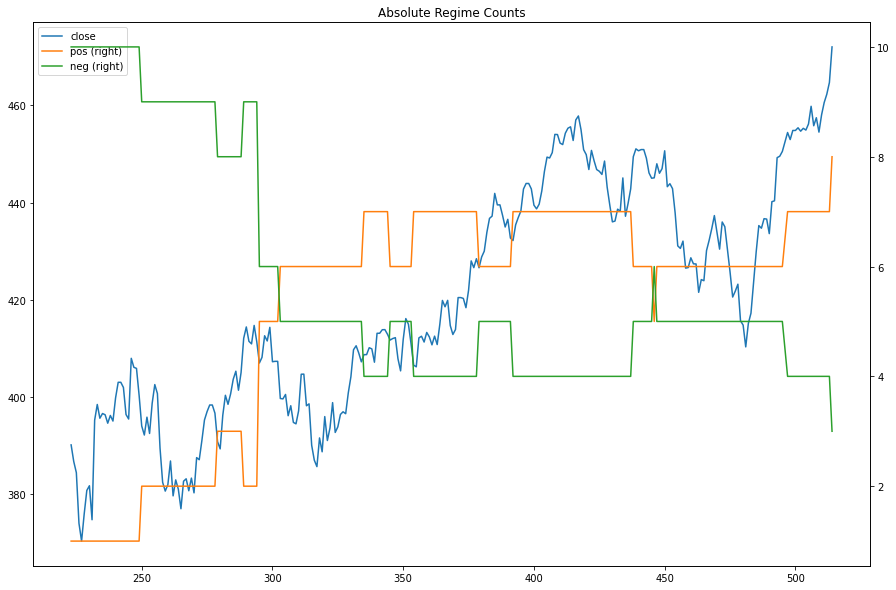

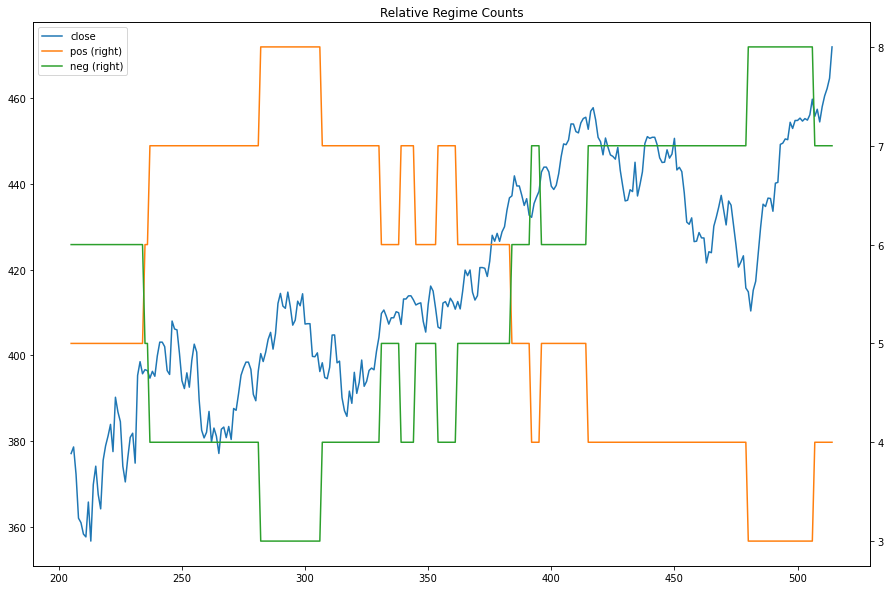

In [5]:
spy_regime = spy_regime.loc[(spy_regime.symbol != 'ONEQ') & (spy_regime.symbol != 'IBKR')].copy()
abs_regime_counts, abs_agg_regimes = aggregate_regime_counts(
    benchmark=spy.loc[spy.is_relative == False].copy(), 
    bench_regime=spy_regime.loc[spy_regime.is_relative == False].copy(),
    by_regime=_agg_by_regime
)
rel_regime_counts, rel_agg_regimes = aggregate_regime_counts(
    benchmark=spy.loc[spy.is_relative == False].copy(), 
    bench_regime=spy_regime.loc[spy_regime.is_relative == True].copy(),
    by_regime=_agg_by_regime
)

abs_regime_counts.plot(figsize=(15, 10), secondary_y=['neg', 'pos'], title='Absolute Regime Counts')
rel_regime_counts.plot(figsize=(15, 10), secondary_y=['neg', 'pos'], title='Relative Regime Counts')

In [6]:
# current scoreboard (current values) of aggregate regime in absolute, relative as one dataframe
current_regime = pd.DataFrame({
    'absolute': abs_agg_regimes.iloc[-1],
    'relative': rel_agg_regimes.iloc[-1],
})
current_regime['delta'] = abs(current_regime.relative - current_regime.absolute)
current_regime

,absolute,relative,delta
XLE,1.0,-1.0,2.0
XLF,1.0,1.0,0.0
XLU,-1.0,-1.0,0.0
XLI,1.0,-1.0,2.0
XLK,1.0,1.0,0.0
XLV,-1.0,-1.0,0.0
XLY,1.0,1.0,0.0
XLP,-1.0,-1.0,0.0
XLB,1.0,-1.0,2.0
XLC,1.0,1.0,0.0
